# Investigating Ranks
In the first section, I am going to investigate what an appropriate rank to consider should be. It will make sense to look at the 
ranks of a trained matrix and a randomly initialized matrix. We will start by looking at a randomly initialized matrix and then
look at a trained matrix. Specifically, I will look at the rank of a randomly initialized matrix. I will need to consider the sizes 
that are seen in RoBERTa

## Imports and Helper Functions

In [1]:
# Import Appropriate Libraries
%load_ext autoreload
    
import torch
import matplotlib.pyplot as plt 
import bisect
import sys
sys.path.append("../")

# Set Logging Level
import logging
level = logging.DEBUG
logging.getLogger("requests").setLevel(level)
logging.getLogger("urllib3").setLevel(level)

In [4]:
def get_principle_direction(A, exp_var):
    U, S, V = torch.linalg.svd(A)
    X = (torch.cumsum(S, 0) / S.sum().item()).tolist()
    num = bisect.bisect(X, exp_var)
    return num

## Normally Initialized Matrix Analysis

In [4]:
def plot_results(n=100, size=[768, 768], exp_var=0.99):
    results = []
    for _ in range(n):
        A = torch.randn(size)
        num = get_principle_direction(A, exp_var)
        results.append(num)
    return results

(array([51.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]),
 array([515. , 515.1, 515.2, 515.3, 515.4, 515.5, 515.6, 515.7, 515.8,
        515.9, 516. ]),
 <BarContainer object of 10 artists>)

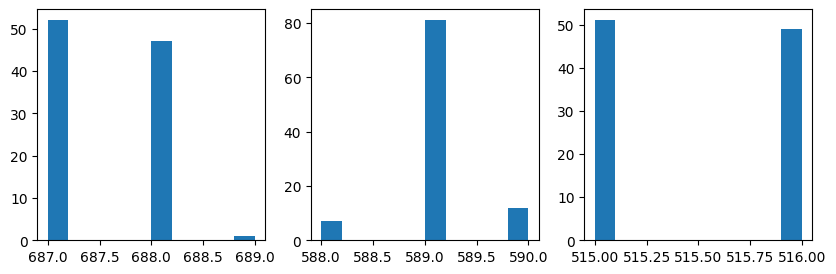

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].hist(plot_results())
ax[1].hist(plot_results(exp_var=0.95))
ax[2].hist(plot_results(exp_var=0.9))

The above results indicate the rank is very tightly distributed based on the explained variance. The reader is encouraged to play with the explained_variance and support the claim themselves.

## Analysis of RoBERTa pre-trained Weights 

In [5]:
## Now let's look at how tightly the weights are distributed in RoBERTa 
from transformers import AutoModel, AutoConfig

In [9]:
# Extract RoBERTa Configuration
roberta_base_config = AutoConfig.from_pretrained('roberta-base')
roberta_large_config = AutoConfig.from_pretrained('roberta-large')

In [10]:
# Extract RoBERTa Model
roberta_base_model = AutoModel.from_config(roberta_base_config)
roberta_large_model = AutoModel.from_config(roberta_large_config)

In [11]:
def print_principle_direction(model, exp_var):
    for key, param in model.named_parameters():
        with torch.no_grad():
            key = ".".join(key.split(".")[3:])
            p_size = min(param.size())
            if len(param.size()) < 2:
                continue
            print(key, get_principle_direction(param, exp_var), p_size)

In [13]:
explained_variance = 0.99
print("# Roberta Base Principle Directions \n")
print_principle_direction(roberta_base_model, explained_variance)

print("\n# Roberta Large Principle Directions \n")
print_principle_direction(roberta_large_model, explained_variance)

# Roberta Base Principle Directions 

 759 768
 492 514
 0 1
attention.self.query.weight 687 768
attention.self.key.weight 687 768
attention.self.value.weight 687 768
attention.output.dense.weight 687 768
intermediate.dense.weight 753 768
output.dense.weight 753 768
attention.self.query.weight 688 768
attention.self.key.weight 687 768
attention.self.value.weight 687 768
attention.output.dense.weight 688 768
intermediate.dense.weight 753 768
output.dense.weight 753 768
attention.self.query.weight 688 768
attention.self.key.weight 688 768
attention.self.value.weight 687 768
attention.output.dense.weight 688 768
intermediate.dense.weight 753 768
output.dense.weight 753 768
attention.self.query.weight 688 768
attention.self.key.weight 688 768
attention.self.value.weight 687 768
attention.output.dense.weight 687 768
intermediate.dense.weight 753 768
output.dense.weight 753 768
attention.self.query.weight 687 768
attention.self.key.weight 688 768
attention.self.value.weight 687 768
attention

On the surface, the above results suggest you need most of the directions to account for the explained variance in the parameters.
As such, we finetune the models for SQuAD and review the difference in the weights of the base and the tuned model. If the difference has 
fewer principle directions with high explanation, it would mean it is possible the task-based fine-tuning can be done in a smaller subspace. 

## Rank Variation During Training

In [14]:
# Get Dataset
import hydra
from omegaconf import DictConfig, OmegaConf
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from train.train import train_epoch
from utils.metrics import AverageMeter

In [15]:
# Extract Training Configuration
with hydra.initialize(version_base=None, config_path="../config"):
    cfg = hydra.compose(config_name="app_config")

In [16]:
train_dataset = load_dataset("squad", split="train")
val_dataset = load_dataset("squad", split="validation")

In [28]:
## Create Training Artifacts
training_cfg = hydra.utils.instantiate(cfg.model.model.train)

train_loader = DataLoader(train_dataset, batch_size=training_cfg.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=training_cfg.batch_size)

model = roberta_base
optimizer = AdamW(params=model.parameters(), lr=training_cfg.lr, weight_decay=training_cfg.weight_decay)
criterion = CrossEntropyLoss()

loss_meter = AverageMeter()
acc_meter = AverageMeter()

In [42]:
for item in train_loader:
    print(item.keys())
    print(item['question'])
    print(item['context'])
    print(item['answers']['answer_start'])
    break

dict_keys(['id', 'title', 'context', 'question', 'answers'])
['What was the purpose of the fruit walls built by French and English farmers?', 'What happened which ended in two puppet states dissolving and Soviet withdrawal out of Iran after WWII?', 'Where can Adobe Flash now be used?', 'What two-letter abbreviation is used for undergraduate engineering  courses?', 'For what did the college pay a substancial sum and donate 4.5 hectres of land?', 'What kind of linguistic choices does Catalan have?', 'Who led the Civil Rights movement?', 'How many households were the offices of Qianhu in charge of?']
['Agriculture and horticulture seek to optimize the capture of solar energy in order to optimize the productivity of plants. Techniques such as timed planting cycles, tailored row orientation, staggered heights between rows and the mixing of plant varieties can improve crop yields. While sunlight is generally considered a plentiful resource, the exceptions highlight the importance of solar en

# Introducing LoRA Weights
This section introduces LoRA weights in our models for further analysis.

In [3]:
# On the surface the above results suggest you need most of the directions to account for most of the directions. 
# It will be useful to see which directions are affected and how later.
from models.LoRA import LoRALinearLayer
def add_linear_lora(module, rank, init_type=0):
    for key, child in module.named_children():
        if isinstance(child, torch.nn.Linear):
            lora_layer =  LoRALinearLayer(child, rank=rank, init_type=init_type)
            setattr(module, key, lora_layer)
        else:
            add_linear_lora(child, rank, init_type)

In [4]:
add_linear_lora(roberta_base, rank=10, init_type=1)

In [5]:
roberta_base

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 768, padding_idx=1)
        (layernorm_embedding): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-11): 12 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (v_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (q_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (out_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
            )
            (self_attn_layer_norm): LayerNorm

In [6]:
roberta_large

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-23): 24 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
       

In [47]:
from transformers import AutoTokenizer, AutoModel, AutoConfig

In [48]:
model_config = AutoConfig.from_pretrained('roberta-base')

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /roberta-base/resolve/main/config.json HTTP/1.1" 200 0


In [49]:
model = AutoModel.from_config(model_config)